Install packages

In [ ]:
!pip install pandas numpy tensorflow matplotlib keras_tuner


Import packages

In [ ]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import layers,models
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
from tensorflow import keras
import keras_tuner as kt


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaymann/handwritten-english-characters-and-digits")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'handwritten-english-characters-and-digits' dataset.
Path to dataset files: /kaggle/input/handwritten-english-characters-and-digits


In [ ]:
import os
print("Files in dataset folder:")
print(os.listdir(path))

Files in dataset folder:
['handwritten-english-characters-and-digits', 'image_labels.csv', 'augmented_images']


In [ ]:
train_dir = os.path.join(path, "handwritten-english-characters-and-digits/combined_folder/train") #'/kaggle/input/handwritten-english-characters-and-digits/handwritten-english-characters-and-digits/combined_folder/train'
test_dir  = os.path.join(path, "handwritten-english-characters-and-digits/combined_folder/test") #'/kaggle/input/handwritten-english-characters-and-digits/handwritten-english-characters-and-digits/combined_folder/test'
augmented_data= os.path.join(path, "augmented_images/augmented_images1") #'/kaggle/input/handwritten-english-characters-and-digits/augmented_images/augmented_images1'

Data preprocessing

In [ ]:
validate_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,              # root directory containing one subfolder per class
    image_size=(128, 128),  # resize every image to 128x128 (bilinear); model input size
    batch_size=32,          # number of samples per batch
    label_mode='categorical'# return one-hot encoded labels (shape: [batch, num_classes])
)

Found 2728 files belonging to 62 classes.


In [ ]:
augmented_ds = tf.keras.utils.image_dataset_from_directory(
    augmented_data,          # root folder containing per-class subdirectories
    image_size=(128, 128),   # resize every image to 128x128 (bilinear)
    batch_size=32,           # number of samples per batch
    label_mode='categorical' # return one-hot encoded labels (shape: [B, num_classes])
)

Found 13640 files belonging to 62 classes.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,                # root directory of the test set
    image_size=(128, 128),   # resize all images to 128x128 (bilinear)
    batch_size=32,           # batch size for evaluation
    label_mode='categorical',# one-hot encoded labels (shape: [B, num_classes])
)

Found 682 files belonging to 62 classes.


In [ ]:
augmented_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 62), dtype=tf.float32, name=None))>

Train CNN model

In [ ]:
# Sequential CNN for 62-class handwritten character recognition.
# Design choices:
# - 128x128 inputs to preserve thin strokes.
# - 3x3 convs + BatchNorm + ReLU for stable, efficient feature extraction.
# - Progressive channel widening (32→512) to learn richer features at coarser scales.
# - MaxPooling to downsample; Dropout increases with depth to combat overfitting.
# - GlobalAveragePooling avoids huge dense layers and improves generalisation.

model = models.Sequential([
    # ---- Input & normalization ----
    layers.Input(shape=(128, 128, 3)),
    layers.Rescaling(1./255),              # Scale pixels from [0,255] → [0,1]

    # ---- Block 1: low-level edges/strokes ----
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),  # edge detectors
    layers.BatchNormalization(),                                    # stabilise activations
    layers.Conv2D(32, (3, 3), padding='same', activation='relu'),  # richer low-level features
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),                          # 128→64
    layers.Dropout(0.2),                                            # mild regularisation

    # ---- Block 2: mid-level motifs (corners, junctions) ----
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),                          # 64→32
    layers.Dropout(0.25),

    # ---- Block 3: character parts (loops, crossbars) ----
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),                          # 32→16
    layers.Dropout(0.3),

    # ---- Block 4: higher-level shapes ----
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),                          # 16→8
    layers.Dropout(0.35),

    # ---- Block 5: optional deep features (useful for hard pairs like O/0, l/1) ----
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),                          # 8→4
    layers.Dropout(0.4),

    # ---- Classification head ----
    layers.GlobalAveragePooling2D(),                                # pool per-channel means
    layers.Dense(512, activation='relu'),                           # compact classifier
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(62, activation='softmax')                          # 62-class probabilities
])

model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,016,670 (19.14 MB)

 Trainable params: 5,011,678 (19.12 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),     # smaller LR to avoid overshooting
    loss='categorical_crossentropy',        # multi-class (one-hot) objective
    metrics=['accuracy']                    # report accuracy on train/val
)
# Train on augmented data (improves generalisation) and validate on a clean split.
# If your classes are perfectly balanced, keep class_weight None.
# If they’re imbalanced, pass a dict like {class_index: weight, ...}.
history = model.fit(
    augmented_ds,                           # training dataset (already batched & shuffled)
    validation_data=validate_ds,            # validation dataset (no augmentation)
    epochs=40,                              # upper bound; early stopping will likely cut this
    # class_weight='balanced',              # <-- NOT a valid Keras option; use a dict or compute_weights()
    callbacks=[
        # Stop when val_accuracy stops improving; restore the best weights.
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", mode="max",
            patience=10, restore_best_weights=True
        ),
        # When val_loss plateaus, reduce LR by factor (0.5) down to a floor (1e-7).
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", mode="min",
            factor=0.5, patience=5, min_lr=1e-7
        )
    ]
)

Epoch 1/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 108s 243ms/step - accuracy: 0.0295 - loss: 4.7222 - val_accuracy: 0.0161 - val_loss: 8.3224 - learning_rate: 1.0000e-04
Epoch 2/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 104s 243ms/step - accuracy: 0.1180 - loss: 3.6025 - val_accuracy: 0.1430 - val_loss: 3.3853 - learning_rate: 1.0000e-04
Epoch 3/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 103s 242ms/step - accuracy: 0.2956 - loss: 2.5575 - val_accuracy: 0.3468 - val_loss: 2.3450 - learning_rate: 1.0000e-04
Epoch 4/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 103s 242ms/step - accuracy: 0.4701 - loss: 1.8153 - val_accuracy: 0.5561 - val_loss: 1.4672 - learning_rate: 1.0000e-04
Epoch 5/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 103s 242ms/step - accuracy: 0.5984 - loss: 1.3543 - val_accuracy: 0.6426 - val_loss: 1.1910 - learning_rate: 1.0000e-04
Epoch 6/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 103s 242ms/step - accuracy: 0.6739 - loss: 1.0695 - val_accuracy: 0.5348 - val_loss: 1.7330 - learning_rate: 1.0000e-04
Epoch 7/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 

CNN model tuning

In [ ]:
def build_user_model(num_classes=62):
    model = models.Sequential([
        layers.Input(shape=(128, 128, 3)),   # Expect 128x128 RGB; switch to (128,128,1) if grayscale
        layers.Rescaling(1./255),            # Normalize pixels from [0,255] → [0,1]

        # ----- Block 1: low-level edges/strokes -----
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),  # downsample 128→64
        layers.Dropout(0.2),                    # mild regularisation

        # ----- Block 2: corners/junctions -----
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),  # 64→32
        layers.Dropout(0.25),

        # ----- Block 3: character parts (loops/crossbars) -----
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),  # 32→16
        layers.Dropout(0.3),

        # ----- Block 4: higher-level shapes -----
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),  # 16→8
        layers.Dropout(0.35),

        # ----- Block 5: deepest features (optional but helpful for hard pairs O/0, l/1) -----
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),  # 8→4
        layers.Dropout(0.4),

        # ----- Global pooling + classifier head -----
        layers.GlobalAveragePooling2D(),        # replaces large Dense stacks, fewer params
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')  # 62-class probabilities
    ])
    return model


# Compile + train (one simple function)
def train_simple(
    train_ds,
    val_ds,
    *,
    epochs=40,
    batch_size=64,            # (Not used directly; keep for API symmetry if you batch outside)
    lr=1e-3,                  # starting LR for Adam
    label_smoothing=0.05,     # improves calibration, reduces over-confidence
    augment=True,             # placeholder switch if you later add .map(augment_fn)
    class_weight=None,        # dict: {class_index: weight}; None if balanced
    checkpoint_path="best.keras"
):
    """
    train_ds / val_ds: tf.data.Dataset yielding (image, one_hot_label).
    """
    model = build_user_model(num_classes=62)

    # ----- Optimizer & loss -----
    opt = keras.optimizers.Adam(learning_rate=lr)
    loss = keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)

    # Name the accuracy metric "acc" so we can monitor "val_acc" in callbacks below.
    model.compile(
      optimizer=opt,
      loss=loss,
      metrics=[keras.metrics.CategoricalAccuracy(name="acc")]
    )

    # ----- Callbacks -----
    cbs = [
        # Save the single best model according to validation accuracy
        keras.callbacks.ModelCheckpoint(
            checkpoint_path, save_best_only=True, monitor="val_acc", mode="max"
        ),
        # Stop early if val accuracy stalls; restore best weights
        keras.callbacks.EarlyStopping(
            monitor="val_acc", mode="max", patience=8, restore_best_weights=True
        ),
        # Reduce LR when val loss plateaus to refine the minima
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6
        ),
    ]

    # ----- Train -----
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=cbs,
        class_weight=class_weight,  # None if classes are balanced
        verbose=1
    )

    # ----- Final evaluation on validation set -----
    eval_names = model.metrics_names   # e.g., ['loss', 'acc']
    eval_vals  = model.evaluate(val_ds, verbose=0)
    results    = dict(zip(eval_names, eval_vals))
    return model, history, results


In [ ]:
# ====== Minimal Hyperparameter Tuner (keeps your model exactly as-is) ======
# Purpose: run a tiny grid search over a few training hyperparameters
# by repeatedly calling your existing `train_simple()` function.
# Outputs: the best Keras model (by chosen metric), the best result dict,
# and a leaderboard of all trials saved to tune_leaderboard.json.

import itertools
import json
import time

def tune_simple(
    train_ds,
    val_ds,
    *,
    search_space=None,        # dict of lists, e.g. {"lr":[3e-4,1e-3], "batch_size":[32,64], ...}
    metric="val_acc",         # metric to maximize; must match keys in History (e.g., 'val_acc', 'val_top5')
    epochs_per_trial=20,      # training epochs per trial (keep small for speed)
    verbose=1
):
    """ Runs a tiny grid search over a few hyperparams using your train_simple().
    Returns: best_model, best_result, all_results (sorted) """

    # ----- Default search space (safe & compact if none provided) -----
    if search_space is None:
        search_space = {
            "lr": [3e-4, 1e-3],
            "batch_size": [32, 64],
            "label_smoothing": [0.0, 0.05],
            "augment": [True, False],
        }

    # Build Cartesian product of all hyperparameter combinations
    keys = list(search_space.keys())
    grids = [search_space[k] for k in keys]
    trials = [dict(zip(keys, vals)) for vals in itertools.product(*grids)]

    best_model, best_result = None, None
    all_results = []

    if verbose:
        print(f"Tuning over {len(trials)} trials...")

    for i, params in enumerate(trials, 1):
        if verbose:
            print(f"[{i}/{len(trials)}] Params: {params}")

        # ---- Train once with these params (delegates to YOUR pipeline) ----
        # Note: train_simple compiles the model, sets callbacks, and returns (model, history, results)
        model, history, results = train_simple(
            train_ds, val_ds,
            epochs=epochs_per_trial,
            batch_size=params.get("batch_size"),
            lr=params.get("lr"),
            label_smoothing=params.get("label_smoothing"),
            augment=params.get("augment"),
            # class_weight=None, checkpoint_path can be passed here if desired
        )

        # ---- Score this trial on the requested validation metric ----
        # Keras History stores validation metrics with 'val_' prefix (e.g., 'val_acc').
        # We prefer the last value in history (best-weights may be restored by EarlyStopping).
        hist_metric_vals = history.history.get(metric, None)
        hist_metric_val = hist_metric_vals[-1] if hist_metric_vals else None

        # Fallback: if not found in history, pull from final evaluation dict
        # (results keys are typically metric names *without* 'val_' prefix).
        fallback_key = metric.replace("val_", "")
        score = hist_metric_val if hist_metric_val is not None else results.get(fallback_key, None)

        trial_result = {
            "trial": i,
            "params": params,
            "metric": metric,
            "score": float(score) if score is not None else None,
            "final_eval": results,   # includes 'loss' and 'acc' on val_ds from model.evaluate
        }
        all_results.append(trial_result)

        # ---- Track best-performing trial ----
        if best_result is None or (score is not None and score > best_result["score"]):
            best_result = trial_result
            best_model = model
            if verbose and score is not None:
                print(f"  ↳ New best {metric}: {best_result['score']:.4f}")

    # ---- Sort leaderboard by score (descending) and save to JSON ----
    all_results = sorted(
        all_results,
        key=lambda r: (r["score"] is not None, r["score"]),
        reverse=True
    )
    with open("tune_leaderboard.json", "w") as f:
        json.dump(all_results, f, indent=2)

    if verbose and best_result is not None:
        print("Tuning finished. Best params:", best_result["params"],
              f"{metric}={best_result['score']:.4f}")

    return best_model, best_result, all_results


Find out CNN best tuning parameters

In [ ]:
# Define a compact hyperparameter grid for tuning.
# Rationale:
# - 'lr': explore a cautious (1e-4) vs. standard (1e-3) Adam learning rate.
# - 'batch_size': larger batches (64, 96) often stabilise BatchNorm; adjust if memory-limited.
# - 'label_smoothing': modest smoothing (0.05, 0.1) can improve calibration/generalisation.
# - 'augment': locked to True to keep train/val protocol consistent with your best CNN runs.
search_space = {
    "lr": [1e-4, 1e-3],
    "batch_size": [64, 96],
    "label_smoothing": [0.05, 0.1],
    "augment": [True],          # lock augmentation on
}

# Run the minimal tuner over the specified grid.
# - metric: rank trials by validation accuracy ('val_acc'); use 'val_top5' if you added that metric.
# - epochs_per_trial: quick-but-meaningful passes; increase for more reliable ranking.
best_model, best_result, leaderboard = tune_simple(
    augmented_ds, validate_ds,
    metric="val_acc",          # or "val_top5" if tracked in model.compile()
    search_space=search_space,
    epochs_per_trial=40        # increase if EarlyStopping is too aggressive
)

# Inspect the winning hyperparameters and score.
print("Best params:", best_result["params"])
print("Best score:", best_result["score"])


Tuning over 8 trials...
[1/8] {'lr': 0.0001, 'batch_size': 64, 'label_smoothing': 0.05, 'augment': True}
Epoch 1/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 109s 245ms/step - acc: 0.0294 - loss: 4.7336 - val_acc: 0.0213 - val_loss: 8.0605 - learning_rate: 1.0000e-04
Epoch 2/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 105s 245ms/step - acc: 0.1103 - loss: 3.7288 - val_acc: 0.1129 - val_loss: 3.6224 - learning_rate: 1.0000e-04
Epoch 3/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 104s 244ms/step - acc: 0.2851 - loss: 2.7391 - val_acc: 0.2540 - val_loss: 3.1441 - learning_rate: 1.0000e-04
Epoch 4/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 104s 244ms/step - acc: 0.4794 - loss: 2.0314 - val_acc: 0.1972 - val_loss: 5.3581 - learning_rate: 1.0000e-04
Epoch 5/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 105s 245ms/step - acc: 0.6035 - loss: 1.6301 - val_acc: 0.6954 - val_loss: 1.3991 - learning_rate: 1.0000e-04
Epoch 6/40
427/427 ━━━━━━━━━━━━━━━━━━━━ 104s 244ms/step - acc: 0.6911 - loss: 1.3908 - val_acc: 0.6891 - val_loss: 1.4214 - learning_rate: 1.0000

In [ ]:
def predict_on_dataset(model, ds):
    """Returns (y_true, y_pred, y_prob) for a (image, one_hot) dataset."""

    y_true, y_pred, y_prob = [], [], []

    for images, labels in ds:
        # Forward pass: shape [B, num_classes]; assumes model ends with softmax.
        probs = model.predict(images, verbose=0)

        # Collect predictions and targets per batch
        y_prob.append(probs)                         # store probabilities
        y_pred.append(np.argmax(probs, axis=1))     # argmax → predicted class id
        # Convert one-hot ground truth to class ids; if labels are sparse ints,
        # use labels.numpy() directly instead of tf.argmax(...)
        y_true.append(tf.argmax(labels, axis=1).numpy())

    # Concatenate all batches into contiguous arrays
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    y_prob = np.concatenate(y_prob)

    # NOTE:
    # - Ensure ds has shuffle=False for deterministic evaluation order.
    # - If memory is tight, compute metrics incrementally instead of concatenating.
    return y_true, y_pred, y_prob

# Inference on the held-out test set using the tuned/best model.
y_true, y_pred, y_prob = predict_on_dataset(best_model, test_ds)


Classification report

In [ ]:
# Get the human-readable class labels inferred from the test directory
# (image_dataset_from_directory sorts subfolder names alphabetically).
class_names = test_ds.class_names
# Print per-class precision, recall, F1, and support, plus macro/weighted averages.
# y_true: ground-truth class indices; y_pred: predicted class indices.
# target_names maps numeric indices → label strings for a readable report.
print(classification_report(y_true, y_pred, target_names=class_names))


              precision    recall  f1-score   support

           0       0.55      0.55      0.55        11
           1       0.53      0.91      0.67        11
           2       0.92      1.00      0.96        11
           3       1.00      1.00      1.00        11
           4       1.00      1.00      1.00        11
           5       1.00      0.82      0.90        11
           6       1.00      1.00      1.00        11
           7       1.00      0.91      0.95        11
           8       1.00      1.00      1.00        11
           9       0.91      0.91      0.91        11
      A_caps       0.92      1.00      0.96        11
      B_caps       1.00      1.00      1.00        11
      C_caps       1.00      0.73      0.84        11
      D_caps       1.00      1.00      1.00        11
      E_caps       1.00      1.00      1.00        11
      F_caps       1.00      0.91      0.95        11
      G_caps       1.00      1.00      1.00        11
      H_caps       1.00    

In [ ]:
Save model to google drive

In [ ]:
# --- Mount Google Drive in Colab so models/artifacts persist across sessions ---
from google.colab import drive
drive.mount('/content/drive')  # authorize in the popup

# --- Create a folder for saved models and tuning outputs ---
from pathlib import Path
SAVE_DIR = Path("/content/drive/MyDrive/lo/models")  # adjust to your preferred folder
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# --- Save the best Keras model (architecture + weights + optimizer state) ---
# .keras format is the recommended TF SavedModel/keras v3 container.
best_model.save(SAVE_DIR / "best_model.keras")

# --- Save tuning results (best trial + full leaderboard) for reproducibility ---
import joblib
joblib.dump(best_result, SAVE_DIR / "tuning_best_result.joblib")   # dict with best params/score
joblib.dump(leaderboard, SAVE_DIR / "tuning_leaderboard.joblib")   # list of trials sorted by score

print("Saved to:", SAVE_DIR)

Mounted at /content/drive
Saved to: /content/drive/MyDrive/lo/models


In [ ]:
from pathlib import Path
import shutil

# Define source (local runtime) and destination (Google Drive) folders
src = Path("/content/models")                         # where files were saved locally
dst = Path("/content/drive/MyDrive/lo/models")        # persistent folder in Drive
dst.mkdir(parents=True, exist_ok=True)                # create if it doesn't exist

# List the artifacts to copy (model + tuning metadata)
for name in ["best_model.keras", "tuning_best_result.joblib", "tuning_leaderboard.joblib"]:
    src_path = src / name
    if src_path.exists():                             # copy only if the file is present
        shutil.copy2(src_path, dst / name)            # copy2 preserves metadata (mtime, etc.)
    else:
        print(f"Warning: missing artifact -> {src_path}")

print("Copied to:", dst)


Copied to: /content/drive/MyDrive/lo/models


In [ ]:
import json
from pathlib import Path

# Directory in Google Drive to persist training artifacts (survives Colab sessions)
SAVE_DIR = Path("/content/drive/MyDrive/lo/models")
SAVE_DIR.mkdir(parents=True, exist_ok=True)  # create the folder tree if it doesn't exist

# Save the Keras History object (dict of lists) to JSON for later plotting/analysis.
# `history.history` typically contains keys like 'loss', 'acc', 'val_loss', 'val_acc', etc.
with open(SAVE_DIR / "history.json", "w") as f:
    json.dump(history.history, f)



Model accuracy

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print(f"Prediction Accuracy: {accuracy*100:.2f}%")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - acc: 0.9025 - loss: 0.7986
Prediction Accuracy: 89.30%


Model outcomes' visualization

In [ ]:

# Make predictions on test_ds
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))              # Convert softmax to class index
    y_true.extend(np.argmax(labels.numpy(), axis=1))     # Convert one-hot to index


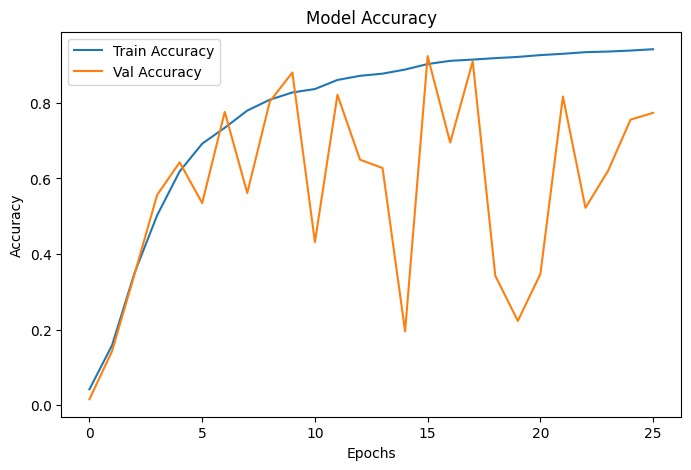

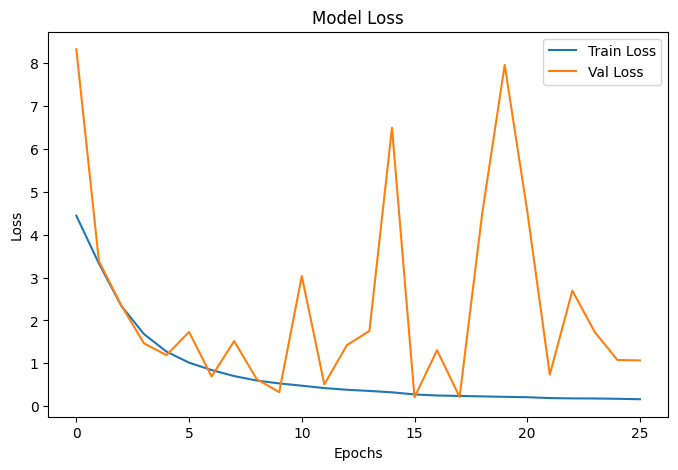

In [ ]:
# Accuracy curves: monitor learning progress and generalisation gap.
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss curves: check optimisation stability and over/underfitting.
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


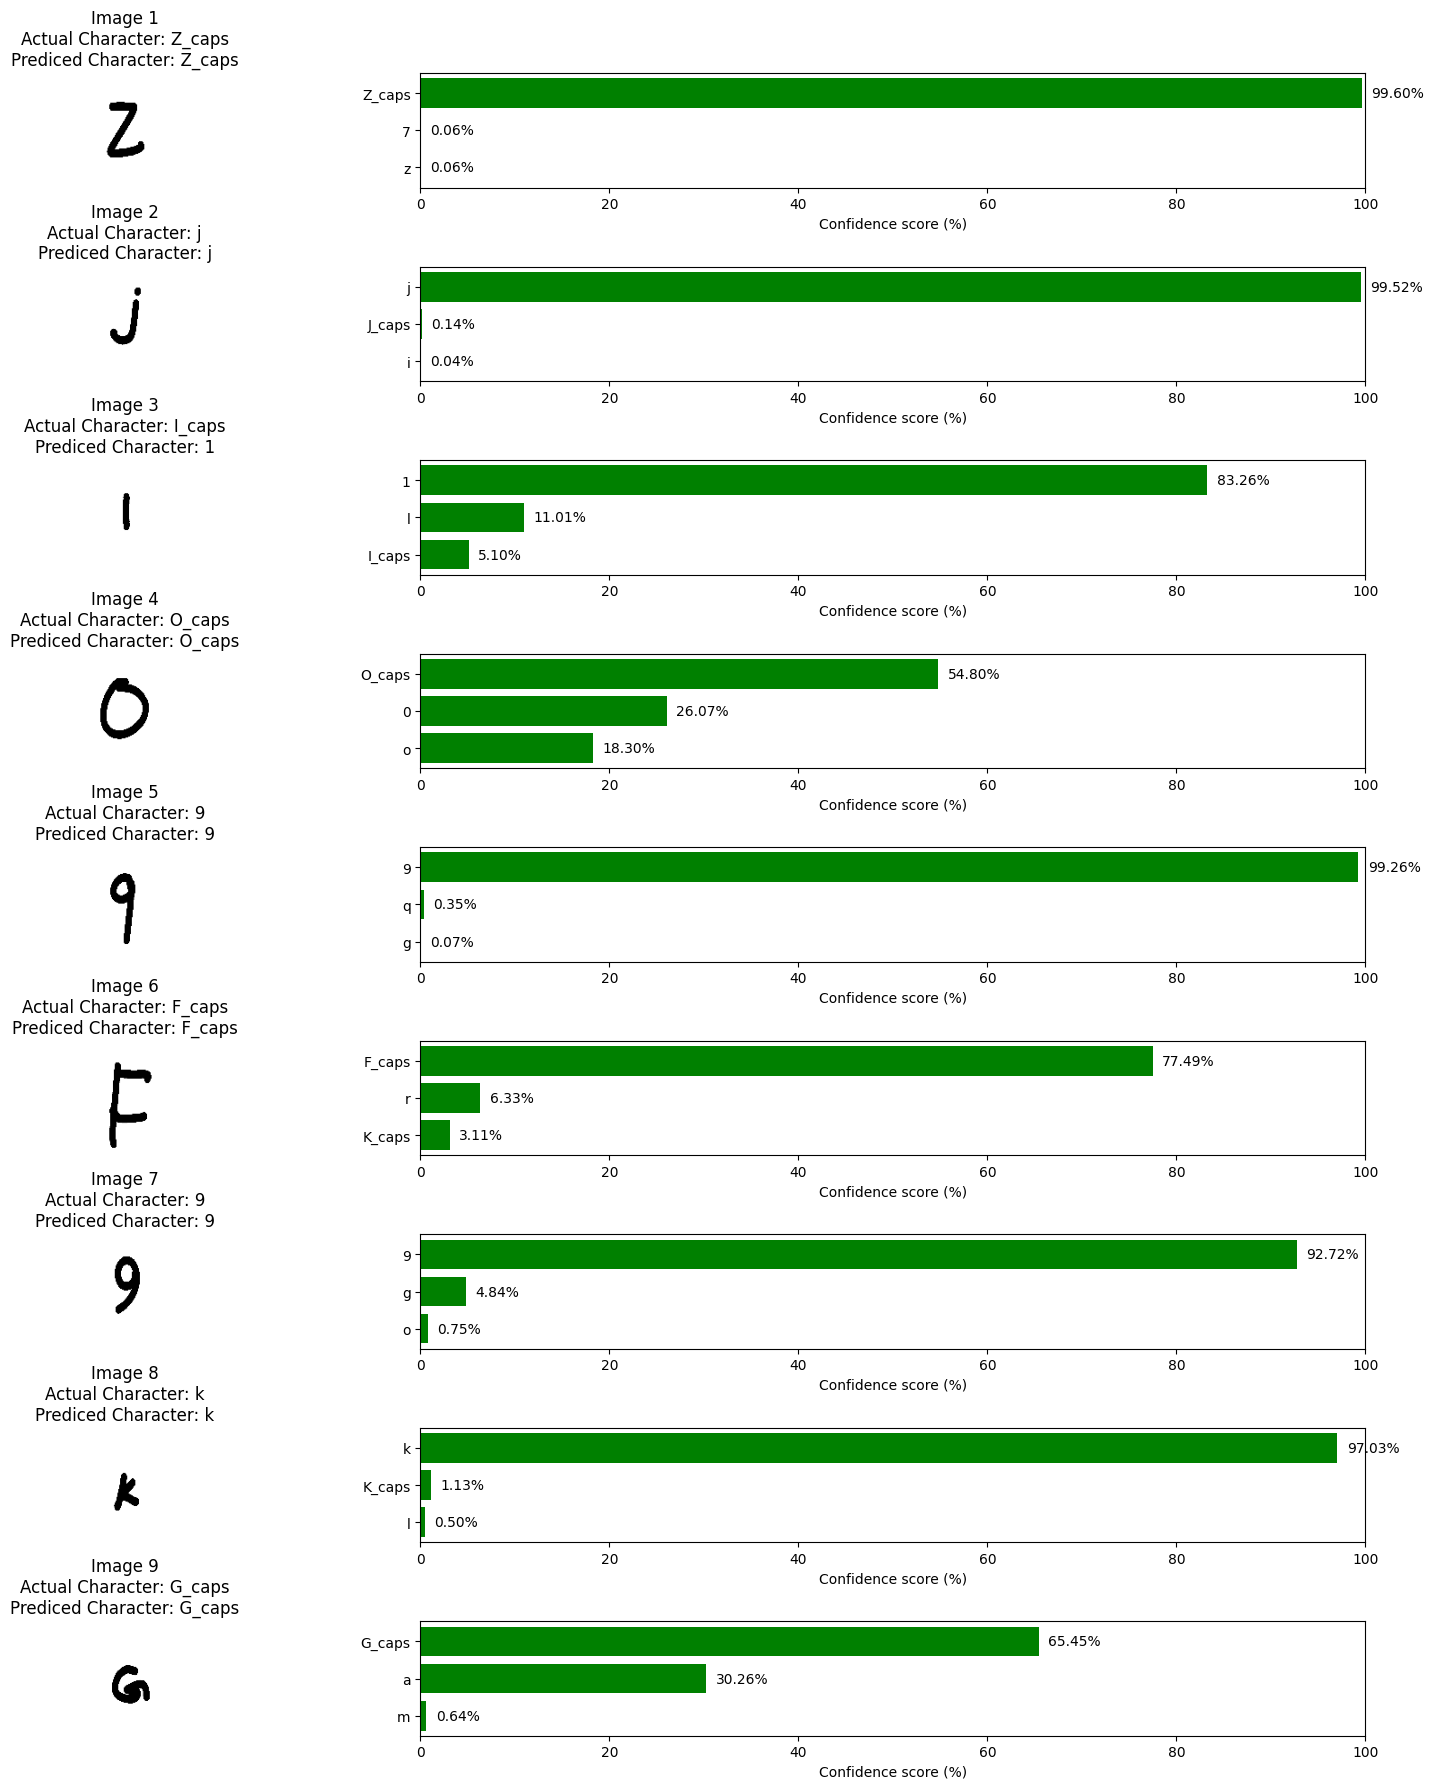

In [ ]:
# Get class names
class_names = test_ds.class_names if hasattr(test_ds, 'class_names') else [str(i) for i in range(62)]

# Take one batch of images and labels
for images, labels in test_ds.take(1):
    preds = model.predict(images)

    # Predicted class index
    pred_classes = np.argmax(preds, axis=1)

    # Convert true labels to integer indices if needed
    if labels.ndim > 1:
        true_classes = np.argmax(labels.numpy(), axis=1)
    else:
        true_classes = labels.numpy()

    # Show 9 predictions with top-3 probability bars
    plt.figure(figsize=(18, 18))
    for i in range(9):
        # -------- Image Plot --------
        plt.subplot(9, 2, 2*i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(f"Image {i+1}\nActual Character: {class_names[int(true_classes[i])]}\nPrediced Character: {class_names[int(pred_classes[i])]}")

        # -------- Probability Bar Plot --------
        top3_idx = np.argsort(preds[i])[-3:][::-1]  # Top 3 class indices
        top3_probs = preds[i][top3_idx]
        top3_labels = [class_names[j] for j in top3_idx]

        plt.subplot(9, 2, 2*i + 2)
        bars = plt.barh(top3_labels, top3_probs * 100, color='green')
        plt.xlim(0, 100)
        plt.xlabel("Confidence score (%)")
        plt.gca().invert_yaxis()  # Highest on top

        for bar in bars:
            width = bar.get_width()
            plt.text(width + 1, bar.get_y() + bar.get_height()/2,
                     f"{width:.2f}%", va='center')

    plt.tight_layout()
    plt.show()